In [1]:
import os
import io
import operator
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.model_selection import LeaveOneOut, KFold
import matplotlib.pyplot as plt
import sklearn.metrics as skm

%matplotlib inline



CHARGED="charged/"
NON_CHARGED="non_charged/"

In [60]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def sorted_dictionary(folder):
    len_file={}
    for filename in os.listdir(folder):
        len_file[filename]=file_len(folder+filename)
    sorted_len_file=sorted(len_file.items(), key=lambda x: -x[1])
    return sorted_len_file

In [62]:
def create_list(fname):
    l=[]
    fname=fname
    file=open(fname,'r')
    file=file.readlines()
    for e in file:
        e=e.replace(' ','')
        e=e[:-1].split(',')
        ideology=float(e[0])
        count=int(e[1])
        freq1=float(e[2])
        freq2=float(e[3])
        duration=float(e[4])
        F11=float(e[5])
        F12=float(e[6])
        F13=float(e[7])
        F21=float(e[8])
        F22=float(e[9])
        F23=float(e[10])
        l.append([ideology,count,freq1,freq2,duration,F11,F12,F13,F21,F22,F23])
    return l       

In [3]:
def create_df(folde):
    l_df=create_df(CHARGED+sorted_len_file[4][0])
    col=['Ideology','Count','Freq1','Freq2','Duration','F11','F12','F13','F21','F22','F23']
    df=pd.DataFrame(l_df)
    df.columns=col
    y=df['Ideology']
    x=df.drop('Ideology',axis=1)
    x=df.drop('Count',axis=1)
    #x['constant']=np.ones(len(x))

In [5]:
l_df=create_df(CHARGED+sorted_len_file[4][0])
col=['Ideology','Count','Freq1','Freq2','Duration','F11','F12','F13','F21','F22','F23']
df=pd.DataFrame(l_df)
df.columns=col
y=df['Ideology']
x=df.drop('Ideology',axis=1)
x=df.drop('Count',axis=1)
#x['constant']=np.ones(len(x))

In [6]:
loo=LeaveOneOut()
y[y>0.5]=1
y[y<0.5]=0

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [7]:
lambdas=np.arange(1e-3,4e-2,1e-3)
def Lasso_ridge_elastic(x,y,lambdas,split_size=20):
    if split_size>len(y):
        if len(y)>1:
            split_size=len(y)
        else:
            return -1
    scores=[]
    kf=KFold(n_splits=split_size)
    for train_index, test_index in kf.split(x):
        history=[]
        X_train, X_test = x.T[train_index].T, x.T[test_index].T
        y_train, y_test = y.T[train_index].T, y.T[test_index].T
        for i in range(len(lambdas)):
            l=lambdas[i]
            lr=Ridge(alpha=l,normalize=True)
            lr.fit(X_train,y_train)
            score=lr.score(X_test,y_test)
            history.append(score)
        scores.append(history)

    s_ridge=np.zeros(len(lambdas))
    for e in scores:
        for i in range(len(e)):
            s_ridge[i]+=e[i]/len(scores)

    scores=[]
    for train_index, test_index in kf.split(x):
        history=[]
        X_train, X_test = x.T[train_index].T, x.T[test_index].T
        y_train, y_test = y.T[train_index].T, y.T[test_index].T
        for i in range(len(lambdas)):
            l=lambdas[i]
            lr=Lasso(alpha=l,normalize=True)
            lr.fit(X_train,y_train)
            score=lr.score(X_test,y_test)
            history.append(score)
        scores.append(history)

    s_lasso=np.zeros(len(lambdas))
    for e in scores:
        for i in range(len(e)):
            s_lasso[i]+=e[i]/len(scores)

    scores=[]
    for train_index, test_index in kf.split(x):
        history=[]
        X_train, X_test = x.T[train_index].T, x.T[test_index].T
        y_train, y_test = y.T[train_index].T, y.T[test_index].T
        for i in range(len(lambdas)):
            l=lambdas[i]
            lr=ElasticNet(alpha=l,normalize=True)
            lr.fit(X_train,y_train)
            score=lr.score(X_test,y_test)
            history.append(score)
        scores.append(history)

    s_elastic=np.zeros(len(lambdas))
    for e in scores:
        for i in range(len(e)):
            s_elastic[i]+=e[i]/len(scores)
    return s_lasso, s_ridge, s_elastic

In [8]:
s_lasso, s_ridge, s_elastic=Lasso_ridge_elastic(x,y,lambdas,20)

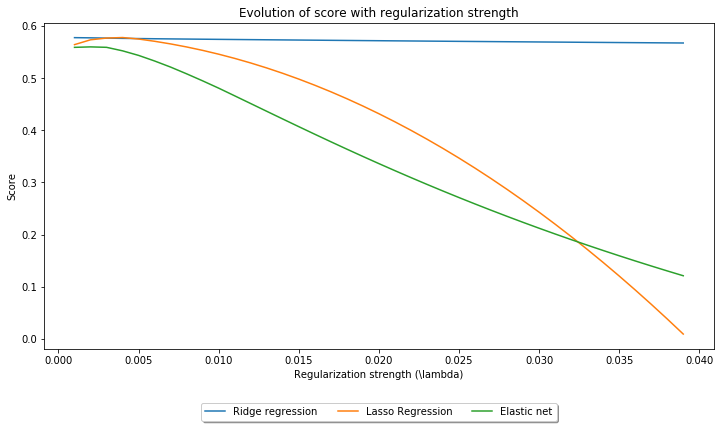

In [9]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.plot(lambdas,s_ridge,label='Ridge regression')
plt.plot(lambdas,s_lasso,label='Lasso Regression')
plt.plot(lambdas,s_elastic,label='Elastic net')
plt.xlabel('Regularization strength (\lambda)')
plt.ylabel('Score')
plt.title('Evolution of score with regularization strength')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})



In [10]:
lambda_lasso=lambdas[list(s_lasso).index(max(s_lasso))]
lambda_ridge=lambdas[list(s_ridge).index(max(s_ridge))]
lambda_elastic=lambdas[list(s_elastic).index(max(s_elastic))]
def optimal_lambda(s_lasso,s_ridge,s_elastic):
    lambda_lasso=lambdas[list(s_lasso).index(max(s_lasso))]
    lambda_ridge=lambdas[list(s_ridge).index(max(s_ridge))]
    lambda_elastic=lambdas[list(s_elastic).index(max(s_elastic))]
    return lambda_lasso,lambda_ridge,lambda_elastic

In [11]:
print('The lambdas we will choose are \n lambda_lasso='+str(lambda_lasso)+'\n lambda_ridge='+str(lambda_ridge)+'\n lambda_elastic='+str(lambda_elastic))

The lambdas we will choose are 
 lambda_lasso=0.004
 lambda_ridge=0.001
 lambda_elastic=0.002


In [12]:
def AUC_regressor(type_of_regressor,x,y,lambda_lasso=lambda_lasso,lambda_ridge=lambda_ridge,lamda_elastic=lambda_elastic,split_size=10):
    if split_size>len(y):
        if len(y)>1:
            split_size=len(y)
        else:
            return -1
    fig = plt.figure(figsize = (12, 6))
    ax = plt.subplot(111)
    kf=KFold(n_splits=split_size)
    for train_index, test_index in kf.split(x):
        history=[]
        X_train, X_test = x.T[train_index].T, x.T[test_index].T
        y_train, y_test = y.T[train_index].T, y.T[test_index].T
        if type_of_regressor=='Ridge':
            lr=Ridge(alpha=lambda_ridge,normalize=True)
        elif type_of_regressor=='Lasso':
            lr=Lasso(alpha=lambda_lasso,normalize=True)
        else:
            lr=ElasticNet(alpha=lambda_elastic,normalize=True)
        lr.fit(X_train,y_train)
        y_predict=lr.predict(X_test)
        y_predict[y_predict>0.5]=1
        y_predict[y_predict<0.5]=0
        y_predict=y_predict.astype(int)
        y_test=y_test.astype(int)
        fpr, tpr, thresholds =skm.roc_curve(y_test,y_predict)
        roc_auc = skm.auc(fpr, tpr)
        print(roc_auc)
        plt.plot(fpr,tpr, label = 'Lasso regression' + ' (AUC = %0.3f)' % roc_auc)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC')
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
        ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
                      shadow = True, ncol = 4, prop = {'size':10})




In [13]:
def Accuracy_regressor(type_of_regressor,x,y,lambda_lasso=lambda_lasso,split_size=10):
    if split_size>len(y):
        if len(y)>1:
            split_size=len(y)
        else:
            return -1
        split_size=len(y)
    kf=KFold(n_splits=split_size)
    accuracy=0
    for train_index, test_index in kf.split(x):
        history=[]
        X_train, X_test = x.T[train_index].T, x.T[test_index].T
        y_train, y_test = y.T[train_index].T, y.T[test_index].T
        if type_of_regressor=='Ridge':
            lr=Ridge(alpha=lambda_ridge,normalize=True)
        elif type_of_regressor=='Lasso':
            lr=Lasso(alpha=lambda_lasso,normalize=True)
        else:
            lr=ElasticNet(alpha=lambda_elastic,normalize=True)
        lr.fit(X_train,y_train)
        y_predict=lr.predict(X_test)
        y_predict[y_predict>0.5]=1
        y_predict[y_predict<0.5]=0
        y_predict=list(y_predict)
        y_test=list(y_test)
        acc=0
        for i in range(len(y_test)):
            if y_test[i]==y_predict[i]:
                acc+=1
        accuracy+=acc/len(y_predict)
    return accuracy/split_size



In [14]:
acc_lasso=[]
acc_ridge=[]
acc_ela=[]
for k in range(2,20,1):
    lasso=Accuracy_regressor('Lasso',x,y,split_size=k)
    ridge=Accuracy_regressor('Ridge',x,y,split_size=k)
    ela=Accuracy_regressor('Elastic',x,y,split_size=k)
    acc_lasso.append(lasso)
    acc_ridge.append(ridge)
    acc_ela.append(ela)


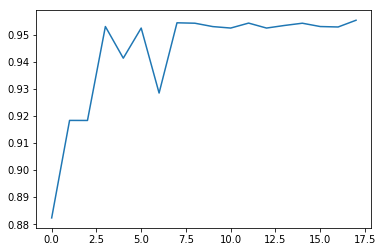

In [15]:
plt.plot(acc_lasso)

In [43]:
lambdas=np.arange(1e-3,4e-2,1e-3)
def accuracy_on_all_files(folder):
    acc_lasso=[]
    acc_ridge=[]
    acc_ela=[]
    x_axis=[]
    k=0
    d_lasso={}
    d_ridge={}
    d_ela={}
    for file in sorted_len_file:
        d_lasso[file_len(folder+file[0])]=[]
        d_ridge[file_len(folder+file[0])]=[]
        d_ela[file_len(folder+file[0])]=[]
    for file in sorted_len_file:
        if k%10==0:
            print(str(100*k/len(sorted_len_file))+"% complete")
        n=file_len(folder+file[0])
        if n<2:
            print(file[0]+"was too small")
        else:
            x_axis.append(file[0])
            df=create_df(folder+file[0])
            col=['Ideology','Count','Freq1','Freq2','Duration','F11','F12','F13','F21','F22','F23']
            df=pd.DataFrame(df)
            df.columns=col
            y=df['Ideology']
            x=df.drop('Ideology',axis=1)
            x=df.drop('Count',axis=1)
            y[y>0.5]=1
            y[y<0.5]=0
            s_lasso, s_ridge, s_elastic=Lasso_ridge_elastic(x,y,lambdas,4)
            lambda_lasso,lambda_ridge,lambda_elastic=optimal_lambda(s_lasso, s_ridge, s_elastic)
            lasso=Accuracy_regressor('Lasso',x,y,split_size=4)
            ridge=Accuracy_regressor('Ridge',x,y,split_size=4)
            ela=Accuracy_regressor('Elastic',x,y,split_size=4)
            acc_lasso.append(lasso)
            acc_ridge.append(ridge)
            acc_ela.append(ela)
            d_lasso[n].append(lasso)
            d_ridge[n].append(ridge)
            d_ela[n].append(ela)
            k+=1
    return acc_lasso,acc_ridge,acc_ela,d_lasso,d_ridge,d_ela,x_axis

In [44]:
acc_lasso,acc_ridge,acc_ela,d_lasso,d_ridge,d_ela,x_axis=accuracy_on_all_files(CHARGED)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.0% complete
6.944444444444445% complete
13.88888888888889% complete
20.833333333333332% complete
27.77777777777778% complete
34.72222222222222% complete
41.666666666666664% complete
48.611111111111114% complete
55.55555555555556% complete
62.5% complete
69.44444444444444% complete
76.38888888888889% complete
LEGISLATIVE_EY_7.0.txtwas too small
76.38888888888889% complete
CONGRESS_AA_2.0.txtwas too small
76.38888888888889% complete
CONSTITUTION_AH_3.0.txtwas too small
76.38888888888889% complete
LEGISLATURE_EY_2.0.txtwas too small
76.38888888888889% complete
LEGISLATIVE_AH_6.0.txtwas too small
76.38888888888889% complete
LEGISLATIVE_EH_5.0.txtwas too small
76.38888888888889% complete
POLICY_IY_6.0.txtwas too small
76.38888888888889% complete
PEOPLE_AH_3.0.txtwas too small
76.38888888888889% complete
POLICY_IY_2.0.txtwas too small
76.38888888888889% complete
GINSBURG_IH_3.0.txtwas too small
76.38888888888889% complete
FEDERAL_ER_4.0.txtwas too small
76.38888888888889% complete
KENNEDY_

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [45]:
length=[]
for i in range(len(x_axis)):
    name=x_axis[i]
    length.append(file_len(CHARGED+name))


In [46]:
for key in d_lasso:
    try:
        d_lasso[key]=sum(d_lasso[key])/len(d_lasso[key])
    except ZeroDivisionError:
        d_lasso[key]=0
for key in d_ridge:
    try:
        d_ridge[key]=sum(d_ridge[key])/len(d_ridge[key])
    except ZeroDivisionError:
        d_ridge[key]=0
for key in d_ela:
    try:
        d_ela[key]=sum(d_ela[key])/len(d_ela[key])
    except ZeroDivisionError:
        d_ela[key]=0




In [47]:
d_lasso_list=[]
for p in length:
    d_lasso_list.append(d_lasso[p])

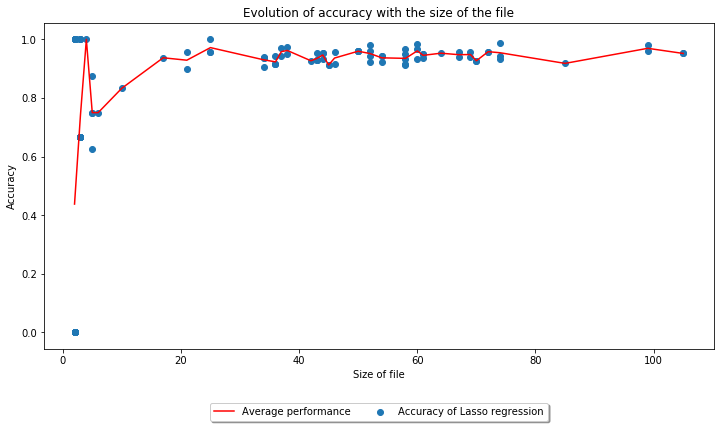

In [48]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.scatter(length,acc_lasso,label='Accuracy of Lasso regression')
plt.plot(length,d_lasso_list,color='r',label='Average performance')
plt.xlabel('Size of file')
plt.ylabel('Accuracy')
plt.title('Evolution of accuracy with the size of the file')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

In [49]:
d_ridge_list=[]
for p in length:
    d_ridge_list.append(d_ridge[p])

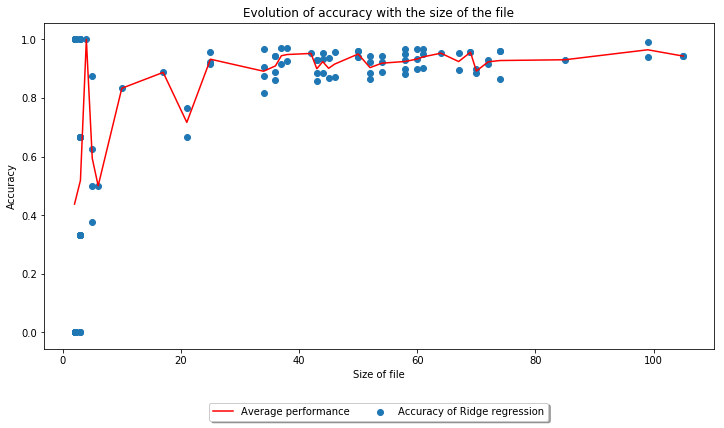

In [50]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.scatter(length,acc_ridge,label='Accuracy of Ridge regression')
plt.plot(length,d_ridge_list,color='r',label='Average performance')
plt.xlabel('Size of file')
plt.ylabel('Accuracy')
plt.title('Evolution of accuracy with the size of the file')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

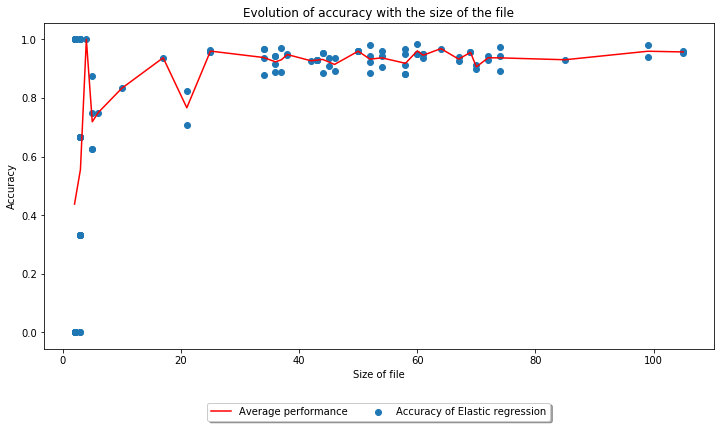

In [51]:
d_ela_list=[]
for p in length:
    d_ela_list.append(d_ela[p])
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.scatter(length,acc_ela,label='Accuracy of Elastic regression')
plt.plot(length,d_ela_list,color='r',label='Average performance')
plt.xlabel('Size of file')
plt.ylabel('Accuracy')
plt.title('Evolution of accuracy with the size of the file')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})





In [54]:
for filename in os.listdir(NON_CHARGED):
    len_file[filename]=file_len(NON_CHARGED+filename)
sorted_len_file=sorted(len_file.items(), key=lambda x: -x[1])


In [55]:
acc_lasso,acc_ridge,acc_ela,d_lasso,d_ridge,d_ela,x_axis=accuracy_on_all_files(NON_CHARGED)

FileNotFoundError: [Errno 2] No such file or directory: 'non_charged/MR_IH_1.0.txt'

In [ ]:
length=[]
for i in range(len(x_axis)):
    name=x_axis[i]
    length.append(file_len(NON_CHARGED+name))
for key in d_lasso:
    try:
        d_lasso[key]=sum(d_lasso[key])/len(d_lasso[key])
    except ZeroDivisionError:
        d_lasso[key]=0
for key in d_ridge:
    try:
        d_ridge[key]=sum(d_ridge[key])/len(d_ridge[key])
    except ZeroDivisionError:
        d_ridge[key]=0
for key in d_ela:
    try:
        d_ela[key]=sum(d_ela[key])/len(d_ela[key])
    except ZeroDivisionError:
        d_ela[key]=0
d_lasso_list=[]
for p in length:
    d_lasso_list.append(d_lasso[p])

fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.scatter(length,acc_lasso,label='Accuracy of Lasso regression')
plt.plot(length,d_lasso_list,color='r',label='Average performance')
plt.xlabel('Size of file')
plt.ylabel('Accuracy')
plt.title('Evolution of accuracy with the size of the file')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

d_ridge_list=[]
for p in length:
    d_ridge_list.append(d_ridge[p])

In [ ]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.scatter(length,acc_ridge,label='Accuracy of Ridge regression')
plt.plot(length,d_ridge_list,color='r',label='Average performance')
plt.xlabel('Size of file')
plt.ylabel('Accuracy')
plt.title('Evolution of accuracy with the size of the file')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

